In [290]:
import nltk
import torch
from sklearn.metrics.pairwise import cosine_similarity
#from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertForSequenceClassification 
import pandas as pd
import numpy as np
import pickle
#from textblob import TextBlob
#from langdetect import detect, detect_langs
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
model_name = "bert-base-uncased"
model_path = "./results/checkpoint-5500"
#tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)

In [12]:
for i in range(11,21):
    df_csv = pd.read_csv('D:/reviewsData/filtered{}.csv'.format(i)).drop(['Unnamed: 0'], axis=1)
    if i > 0:
        df_csv.index = df_csv.index + len(df)
        df = pd.concat([df,df_csv])
    else:
        df = df_csv

In [23]:
reviews = df['review'][df['app_name'] == """PLAYERUNKNOWN'S BATTLEGROUNDS"""]
reviews = reviews[reviews.str.len() > 30].values.tolist()

## Candidate Reviews to Bert Embedding

In [33]:
# with torch.no_grad():
#     character = model(torch.tensor([tokenizer.encode('art')]),output_hidden_states =True)['hidden_states'][-1][:,1,:]
token_frequency = {}
token_feature = {}
for i in range(len(reviews)):
    words = reviews[i]
    input_ids = torch.tensor([tokenizer.encode(words, truncation=True, max_length=512)])
    tokens = tokenizer.tokenize(words)
    with torch.no_grad():
        features = model(input_ids,output_hidden_states=True)['hidden_states'][-1]
        for j in range(features.shape[1]-2):
            if tokens[j] not in token_frequency:
                token_frequency[tokens[j]] = 1
                token_feature[tokens[j]] = features[0,1+j,:]
            else:
                token_frequency[tokens[j]] += 1
                token_feature[tokens[j]] += features[0,1+j,:]
            #print(tokens[j], cosine_similarity(features[:,1+j,:], character))


In [34]:
for k in token_feature.keys():
    token_feature[k] = token_feature[k] / token_frequency[k]

In [35]:
len(token_feature)

22085

In [36]:
import pickle
a_file = open("token_feature_pubg.pkl", "wb")
pickle.dump(token_feature, a_file)
a_file.close()
a_file = open("token_frequency_pubg.pkl", "wb")
pickle.dump(token_frequency, a_file)
a_file.close()

In [37]:
a_file = open("token_feature_pubg.pkl", "rb")
token_feature = pickle.load(a_file)
a_file = open("token_frequency_pubg.pkl", "rb")
token_frequency = pickle.load(a_file)
#df_token_frequency = pd.DataFrame.from_dict(token_frequency, orient='index').rename(columns={0:'frequency'})

## Candidate Nouns Selection

In [38]:
candidate_frequency = {}
candidate_feature = {}

In [ ]:
for i in range(len(reviews)):#len(reviews)
    words = nltk.word_tokenize(reviews[i])
    noun_tags = ('NN','NNS','NNP','VBG')
    word_pos = nltk.pos_tag(words)
    if i % 1000 == 0:
        print(i)
    for word, pos in word_pos:
        if pos in noun_tags:
            if word not in candidate_frequency:
                candidate_frequency[word] = 1
                tokens = tokenizer.tokenize(word)
                candidate_feature[word] = torch.Tensor([0]*768)
                for token in tokens:
                    try:
                        candidate_feature[word] += token_feature[token]
                    except:
                        continue
                if len(tokens) > 0:
                    candidate_feature[word] = candidate_feature[word] / len(tokens)
            else:
                candidate_frequency[word] += 1
                    

## Clustering

In [295]:
candidate_feature_en = {}
candidate_frequency_en = {}
for i,(k,v) in enumerate(candidate_feature.items()):
    #candidate_feature[k] = v.cpu().detach().numpy()
    if len(k) >=3 and candidate_frequency[k] > 10:
#         try:
#             detect(k) = lang
#             if lang == 'en':
        candidate_feature_en[k] = candidate_feature[k]
        candidate_frequency_en[k] = candidate_frequency[k]
#             else:
#                 print(lang, k)
#         except:
#             print(k)

df_candidate_frequency = pd.DataFrame.from_dict(candidate_frequency_en, orient='index').rename(columns={0:'frequency'})
candidate_feature_list = np.stack( list(candidate_feature_en.values()), axis=0 )

In [ ]:
### if nan but no nan now
# for i in range(len(candidate_feature_list)):
#     if np.isnan(candidate_feature_list[i]).any() == True:
#         candidate_feature_list[i] = np.array([0]*768)
#         print(i)

In [576]:
# feature definition
features = ['gameplay', 'price', 'cheat', 'optimization', 'graphic']
feature_centers = np.stack([candidate_feature_en[f] for f in features], axis=0)
feature_index = [list(candidate_feature_en.keys()).index(f) for f in features]

In [577]:
kmeans = KMeans(n_clusters=5, random_state=0, init = feature_centers).fit(candidate_feature_list)
df_candidate = pd.DataFrame(np.array([df_candidate_frequency.index,kmeans.labels_]).transpose(), columns = ['tokens', 'group'])
df_candidate['frequency'] = df_candidate_frequency.values

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


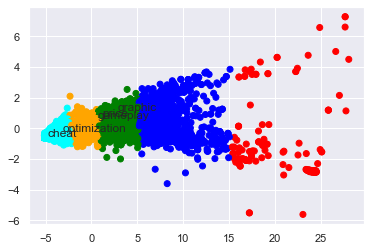

In [675]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(candidate_feature_list)
colors = {0:'green',1:'blue',2:'cyan',3:'orange',4:'red', 5:'brown', 6:'yellow', 7:'purple', 8:'gray'}
plt.scatter(x = principalComponents[:,0], y = principalComponents[:,1], c=df_candidate['group'].map(colors))
for i, txt in enumerate(features):
    plt.annotate(txt, (principalComponents[feature_index[i],0], principalComponents[feature_index[i],1]))

In [723]:
#features = ['gameplay', 'price', 'cheat', 'optimization', 'graphic']
feature_features = [
#gameplay
['recoil','hitting','boosts','spawns','risk','zones','painkillers','crossfire','looting','loot','control'
 ,'reload','callouts','Mini14','Gameplay','solo','friends','kar98','ammo','snakes','armor','parachuting','beryl'],
#price
['budget','£20','discount','sell','price','money','worth'],
#cheat
['teamkillers','infestation','douchebags','bugfixing','WALLHACKERS','hackers','cheaters','cheat'],
#event
#['event'],
#optimization
['optimization','Buggs','buggs','bug','consistent','CPU','performance','unoptimization','frames','maintainance',
 'overloading','server','africa','client','GPU','crash'],
#graphic
['polygons','map','outfit','building','polygon','barbie','beauty','graphic','view','cloth'],
]

## Similarity Comparison

In [724]:
cos_similarities = []
for i in range(len(features)):
    ff = [candidate_feature_en[f] for f in feature_features[i]]
    cos_similarities.append(np.max(cosine_similarity(ff, candidate_feature_list),axis=0))
cos_similarities = np.stack(cos_similarities, axis=0 )
print(cos_similarities.shape)

(5, 16490)


In [725]:
feature_words = []
cos_similarities_group = np.argmax(cos_similarities,axis=0)
cos_index_group = np.array(range(cos_similarities.shape[1]))
topk = 200

for i in range(len(features)):
    cos_group = cos_similarities[:,cos_similarities_group==i][i]
    cos_i_group = cos_index_group[cos_similarities_group==i]
    target_words_index = cos_i_group[np.argsort(cos_group)[::-1][:topk]]
    print(features[i])
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    feature_words.append(df_candidate_frequency.iloc[target_words_index].index.values)
    #print(np.sort(cos_group)[::-1][:topk])
    #cos_in_group

gameplay
price
cheat
optimization
graphic


In [726]:
df_candidate['feature_group'] = np.array([len(features)]*len(df_candidate))
for i in range(len(features)):
    a = [True if t in feature_words[i] else False for t in df_candidate['tokens'].values]
    df_candidate['feature_group'][a] = i
df_candidate

<ipython-input-726-27c19a60de61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_candidate['feature_group'][a] = i


,tokens,group,frequency,feature_group
0,LOOT,3,330,0
1,DIE,3,405,5
2,THATS,2,149,4
3,PUBG,3,38896,5
4,NUT,3,13,5
...,...,...,...,...
16485,REGIONLOCKTHEASIANS,2,12,5
16486,WALLHACKERS,3,24,2
16487,Woody,3,11,5
16488,HAHAHAHHAHAHA,1,76,5


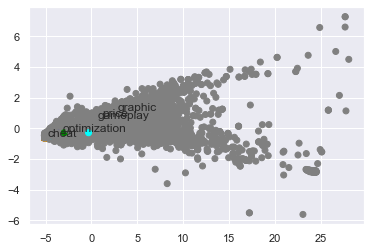

In [727]:
colors = {0:'green',1:'blue',2:'cyan',3:'orange',4:'red', 5:'gray'}
plt.scatter(x = principalComponents[:,0], y = principalComponents[:,1], c=df_candidate['feature_group'].map(colors))
for i, txt in enumerate(features):
    plt.annotate(txt, (principalComponents[feature_index[i],0], principalComponents[feature_index[i],1]))

In [728]:
feature_tag = dict(zip(list(df_candidate[df_candidate['feature_group'] < max(df_candidate['feature_group'])].tokens.values) , list(df_candidate[df_candidate['feature_group'] < max(df_candidate['feature_group'])].feature_group.values)))
a_file = open("feature_tag.pkl", "wb")
pickle.dump(feature_tag, a_file)
a_file.close()

In [729]:
a_file = open("feature_tag.pkl", "rb")
feature_tag = pickle.load(a_file)

## tagging

In [ ]:
candidate_reviews = []
feature_positions = []
for i in range(len(reviews)):#len(reviews)
    if i % 1000 == 0:
        print(i)
    flag = False
    words = nltk.word_tokenize(reviews[i])
    temp_dic = {}
    for word in words:
        if word in feature_tag:
            temp_dic[words.index(word)] = feature_tag[word]
            flag = True
    if flag:
        candidate_reviews.append(reviews[i])
        feature_positions.append(temp_dic)
                    

In [747]:
df_output = pd.DataFrame(np.array([candidate_reviews,feature_positions]).transpose(),columns = ['review','feature_positions'])
df_output.to_csv('feature_extraction_pubg.csv',sep = '\t',index=False)

## usage

In [748]:
from ast import literal_eval
df_test = pd.read_csv('feature_extraction_pubg.csv',sep = '\t')
# if need to transform pandas series back to original type
position_list = [literal_eval(dic) for dic in df_test['feature_positions']]
print(position_list[0])

{1: 0, 3: 4}


In [749]:
df_test

,review,feature_positions
0,CHUTE LOOT DIE THATS PUBG IN A NUT SHELL,"{1: 0, 3: 4}"
1,Graphics are pretty bad but the gameplay is ok...,"{6: 0, 52: 0}"
2,They will ruin your reputation with false bans...,"{7: 2, 13: 0, 42: 1, 79: 1}"
3,☼ Graphics ☼\r\r\n☐ Bad\r\r\n☐ Alright\r\r\n☐ ...,"{86: 0, 133: 1, 178: 1, 184: 1}"
4,Excellent game to play with friends,{5: 0}
...,...,...
129534,"I only played maybe an hour of this game, then...","{12: 2, 51: 2}"
129535,Personally I think its better than warzone jus...,"{9: 0, 14: 4, 15: 2}"
129536,"Honestly this was the best battle royal ever, ...",{9: 4}
129537,games full of hackers and exploiters,"{3: 2, 5: 2}"


## other codes for testing

In [522]:
#word = ""
#input_ids = torch.tensor([tokenizer.encode(word)])
topk = 50
with torch.no_grad():
    i = 2
    #features = model(input_ids,output_hidden_states =True)
    ff = [candidate_feature_en[f] for f in feature_features[i]]
    cos = np.sum(cosine_similarity(ff, candidate_feature_list),axis=0) / len(ff)
    print(features[i])
    target_words_index = np.argsort(cos)[::-1][:topk]
    target_words_cos = sorted(cos)[::-1][:topk]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(df_candidate_frequency.iloc[target_words_index,:])
    print(target_words_cos)
    #print(target_words_index.shape)

cheat
               frequency
microstutters         12
cams                 310
Cams                  11
tabs                  21
CHEATER              531
Cheater              427
cheater             4622
monetisation          53
monetising            14
ticks                 77
renders               60
radars                17
teleportation         45
crapshoot             14
exploiter             11
dips                 131
proofs                14
monetizing            58
INCOMPETENT           14
Incompetent           26
incompetent          144
teleports             40
chineses              66
Chineses              20
abusing              207
specifics             32
rubberbands           23
crashs                22
monitization          46
Miscreated            16
letdown               13
hitboxes             586
Hitboxes             117
HITBOXES              17
countrys              14
aimbotter             77
fests                 12
anti-cheats           29
matchs             

In [ ]:
matching = [s for s in reviews if " hitboxes " in s]
matching

In [268]:
nltk.word_tokenize('optimization')

['optimization']

In [70]:
with torch.no_grad():
    character = model(torch.tensor([tokenizer.encode('character')]),output_hidden_states =True)['hidden_states'][-1][:,1,:]
    
words = 'Geralt'
input_ids = torch.tensor([tokenizer.encode(words, truncation=True, max_length=512)])
with torch.no_grad():
    features = model(input_ids,output_hidden_states =True)
    print(words)
    print(features['hidden_states'][-1][0,:,:].shape)
    print(cosine_similarity(features['hidden_states'][-1][0,:,:], character))

Geralt
torch.Size([5, 768])
[[0.8998311 ]
 [0.9615855 ]
 [0.9530124 ]
 [0.90793467]
 [0.9087192 ]]


In [62]:
r = 'Geralt is a witcher.'
words = nltk.word_tokenize(r)
noun_tags = ('NN','NNS','NNP')
word_pos = nltk.pos_tag(words)
for word, pos in word_pos:
    print(word, pos)
    #if pos in noun_tags:

#print(i, words)

Geralt NNP
is VBZ
a DT
witcher NN
. .
